In [9]:
import json
import time

import cv2
import numpy as np
import pymongo
from scipy.spatial import KDTree

from ir_utils import *

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [45]:
db_cfg_path='./config/database.json'
connect_name='mongodb'
extr_cfg_path='./config/feature_extractor.json'
list_features=['HOG_CIFAR_8x8x16x16']
testset_path = './data/cifar-10/test.json'
trainset_path = './data/cifar-10/train.json'

In [46]:
# with open(db_cfg_path) as f:
#     db_config = json.load(f)
# db_config = db_config[connect_name]
# del db_config['name']
# client = pymongo.MongoClient(**db_config)
# db = client.image_retrieval
# collection = db.image_features
# collection = collection.find()
# collection = list(collection)

with open(extr_cfg_path) as f:
    extractors_cfg = json.load(f)

extractors_dict = dict()

for extractor_cfg in extractors_cfg:
    extractors_dict[extractor_cfg['name']] = extractor_cfg
    
extractors = []
for ft in list_features:
    extractors.append(create_extractor(extractors_dict[ft])['extractor'])
    
pca = PCA(n_components=2)

In [47]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']

all_classes = ['airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse',
          'ship', 'truck']

class_ids = dict()

for i, c in enumerate(all_classes):
    class_ids[c] = i

def get_features(extractors, image):
    features = [extractor.extract(image) for extractor in extractors]
    features = np.concatenate(features)
    return features

def extract_features_and_classes(dataset_des, extractors):
    features = [get_features(extractors, cv2.imread(des['image_path'])) for des in dataset_des]
    classes = [des['image_path'].split('/')[-2] for des in dataset_des]
    return features, classes

def visualize(features, classes, visualized_classes=all_classes, save=False, file_name=None):
    pca.fit(features)
    pca_features = pca.transform(features)
    plt_colors = [colors[class_ids[c]] for c in classes]
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5, forward=True)
    for c in visualized_classes:
        x = []
        y = []
        color = colors[class_ids[c]]
        label = c
        for i in range(pca_features.shape[0]):
            if classes[i] == c:
                x.append(pca_features[i, 0])
                y.append(pca_features[i, 1])
        ax.scatter(x, y, c=color, label=label)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid()
    
    if save:
        plt.savefig(file_name)
    plt.show()

500


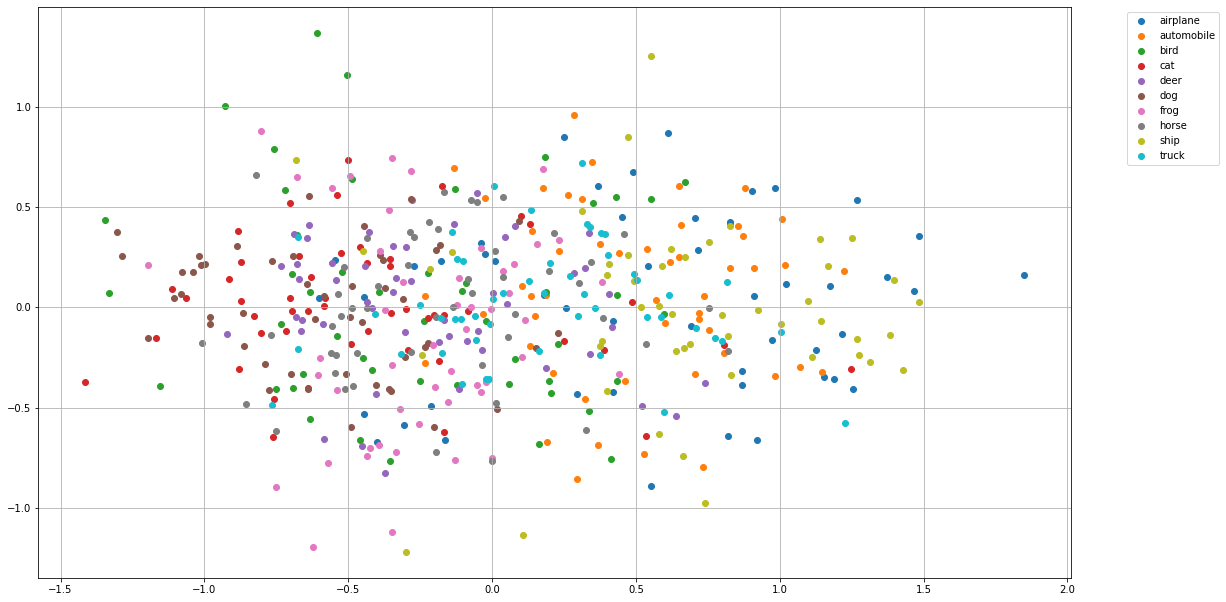

In [48]:
with open(testset_path) as f:
    testset_des = json.load(f)
    
with open(trainset_path) as f:
    trainset_des = json.load(f)
    
data_des = trainset_des + testset_des
# data_des = trainset_des
# data_des = testset_des

data_size = 500
idx_mul = len(data_des) // data_size
data_des = [data_des[i * idx_mul] for i in range(data_size)]
print(len(data_des))
    
features, classes = extract_features_and_classes(data_des, extractors)

visualized_class = all_classes
visualize(features, classes, visualized_class, save=True, file_name='./exp/'+list_features[0]+'_visualize.png')

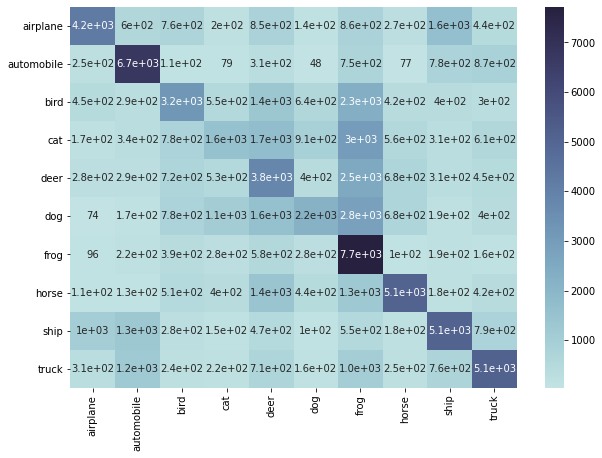

In [58]:
cm = [
    [4243,599,762,198,854,138,855,267,1641,443],
[247,6736,106,79,313,48,752,77,775,867],
[449,293,3246,552,1359,638,2341,418,400,304],
[169,341,780,1553,1725,907,3036,565,312,612],
[276,286,719,534,3829,398,2517,684,306,451],
[74,166,783,1066,1606,2210,2831,683,186,395],
[96,215,387,285,576,277,7711,102,187,164],
[114,129,507,397,1450,442,1259,5106,176,420],
[1039,1328,283,153,473,104,553,181,5100,786],
[310,1187,237,223,707,163,1050,250,762,5111],
]
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cm, index = [i for i in all_classes],
                  columns = [i for i in all_classes])
plt.figure(figsize = (10,7))
cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
sns.heatmap(df_cm, annot=True, cmap=cmap)
plt.savefig('./exp/hog_4x4x16x16_cm.jpg')